In [1]:
pip install yfinance matplotlib numpy pandas scikit-learn tensorflow


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#define the stock symbol and time range
symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-03-15'

#fetch stock data
stock_data = yf.download(symbol, start=start_date, end=end_date)

#preview the data
stock_data.head()
stock_data = stock_data[['Close'  ]]
stock_data['Date'] = stock_data.index

#Normalize the data using MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

#add additional features like moving average
window_size = 60
for i in range(1, window_size + 1):
    stock_data[f'MA_{i}'] = stock_data['Close'].rolling(window=i).mean()


[*********************100%***********************]  1 of 1 completed


In [14]:
#train test split
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
time_step = 60


In [ ]:
#model selection use LSTM for time series data
#create sequences from the data
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        targets.append(data[i+window_size])
    return np.array(sequences)

sequence_length = 30 #you can change the sequence length
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)

#Reshape data to [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Build the LSTM MODEL
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#train the model
model.fit(X_train, train_data[sequence_length:], epochs=100, batch_size=32)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0274
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.4133e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.8465e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7054e-04
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5692e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.2858e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.1892e-04
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.2133e-04
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.4820e-04
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.2842e-04
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0258e-04
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.7304e-04
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.0228e-04
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9069e-04
Epoch 15/100
63/6

In [ ]:
future_days = 30  # Predict next 30 days
last_60_days = scaled_data[-time_step:].reshape(1, time_step, 1)

predicted_prices = []
for _ in range(future_days):
    pred = model.predict(last_60_days)
    predicted_prices.append(pred[0][0])
    last_60_days = np.append(last_60_days[:, 1:, :], [[pred[0][0]]], axis=1)

# Convert predictions back to original price scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1,1))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


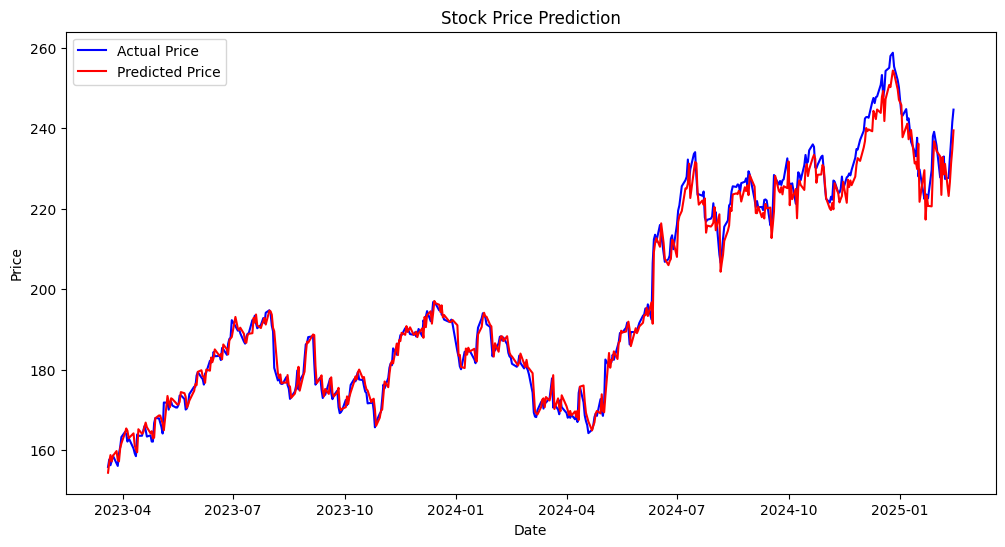

In [12]:
#Model evaluation
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

#visualize the results
plt.figure(figsize=(12,6))
plt.plot(stock_data['Date'][train_size+sequence_length:], stock_data['Close'][train_size+sequence_length:], label='Actual Price', color='blue')
plt.plot(stock_data['Date'][train_size+sequence_length:], predictions, label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [13]:
#Calculate the error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(test_data[sequence_length:], predictions)
mae = mean_absolute_error(test_data[sequence_length:], predictions)
r2 = r2_score(test_data[sequence_length:], predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 38696.56027512866
Mean Absolute Error: 195.18895010350752
R-squared: -3266239.457559619
